## Assignment 06

**Students:**
- Franklin Ruben Rosembluth Prado
- Sharon Sarai Maygua Mendiola

## Introduction

**Reinforcement learning** is an area of Artificial Intelligence that helps an agent perform determined actions in order to reach a particular goal.

This method can have different applications such as self-driving cars or playing games:


- Reinforcement learning consists in having an agent that can be in different states, and perform certain actions in each given state.

- Making an action in a given state results in a new state for the agent. The agent must have a goal state that can be reached by performing a list of defined actions, the idea is to teach the agent how to reach the goal state, the agent must learn to make decisions regarding which action to take in each state.

- The most important thing in the algorithm is the way it saves the information of which actions can have a good or bad reward, and which actions will really lead the agent to the goal state.

- The algorithm known as Bellman algorithm has a Q-table in order to store information of each state, and for each state the expected reward of each action the agent can take in.

- An agent must be rewarded or penalized in order to make him learn better actions.

- This expected reward is a metric that tells the agent how good or bad it is to take each of the possible actions that can do, As the agent learns, these rewards change, until the agent reaches the point where the reward is maximized and it cannot improve more, when this happens the agent has reached an **optimal policy**.

- **The optimal policy** can be defined as the best possible actions that the agent can make in each state in order to maximize the reward.

- The main objective of Reinforcement Learning is finding the optimal policy in the problem.

For this practice, we will apply RL using Q-learning, The environment consists on Harry Potter (agent) going through the **"Prison of Azkavan"** in order to save Sirius Black (goal), the representation of the prison has 9 columns and 7 rows.

Harry starts at position (1,1) and Sirius is prisioned on (7,4). In columns 3, 4, and 5 exists windy columns going from south to north that makes Harry in hurry and difficult situations to get to Sirius Black.

# Problem with Q-learning

1. How do you plan to resolve this problem using Q-learning? - ¿Cómo planeas resolver el problema usando q-learning?

- To implement Q-learning with the problem, we need to analyze what type of rewards the agent will receive according to the states it may have through the iteration.
- Finding which would be the best values to obtain an optimal policy that allows the agent to make better decisions.
- We started giving the agent this goals:
- **-10** from Falling out of the board, **-1** for every step that the agent makes and **100** if the agent reaches the goal state.
- We thought about the values that the agent could obtain when a is making a step. Firstly we use negative rewards (penalize) with the idea that if the agent falls of the map or makes bad steps, the agent would lose rewards after reaching the goal, that's why instead of concentrating on finding more unuseful path, the agent should go to the goal directly.

- The code that we suggest to resolve this particular problem is here:

In [ ]:
import numpy as np
import gym
from gym import spaces
import random
from copy import copy
from termcolor import colored, cprint
import time
import math
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from PIL import Image

# Create the environment

The "create_map" function, creates a map that is represented as a two-dimensional array. The values used are: 0 for empty space, 1 for the start position and 2 for the target position. This function is useful because it generates a learning environment where a learning reinforcement agent must traverse from the start position to the target position

In [ ]:
# 0 = empty_space; 1 = init_pos; 2 = goal_pos
def create_map(size, init_position, goal_pos):
    map = np.zeros((size[1], size[0]), dtype=np.int)
    map[init_position[1], init_position[0]] = 1
    map[goal_pos[1], goal_pos[0]] = 2
    return map

In [ ]:
map_size = (9, 7)
init_pos = (1, 1)
goal_pos = (7, 4)
map = create_map(map_size, init_pos, goal_pos)
print(map)

[[0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


Initialization of the action space, the state space, and creation of the Q table

In [ ]:
action_space_size = 8 # UP, RIGHT, DOWN, LEFT UP_RIGHT, ..., DOWN_LEFT
state_space_size = map_size[0] * map_size[1] # AREA
print(action_space_size, state_space_size)

q_table = np.zeros((state_space_size, action_space_size))

print(q_table.shape)

8 63
(63, 8)


In [ ]:
# actions_dict = {0: 'up', 1: 'down', 2: 'left', 3: 'right', 4: 'up_right', 5: 'up_left', 6: 'down_right', 7: 'down_left'}
actions = ['up', 'down', 'left', 'right', 'up_right', 'up_left', 'down_right', 'down_left']
print(actions[1])

down


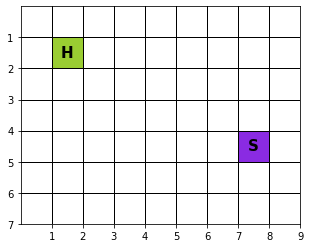

In [ ]:
def show_map_3(map):
    row_labels, col_labels = range(map.shape[0]+1), range(map.shape[1]+1)
    cmap = ListedColormap(['white', 'yellowgreen', 'blueviolet'])
    norm = Normalize(vmin=0, vmax=2)
    plt.imshow(map, cmap=cmap, norm=norm)
    plt.xticks(np.arange(len(col_labels)-1) + 0.5, col_labels[1:])
    plt.yticks(np.arange(len(row_labels)-1) + 0.5, row_labels[1:])
    plt.grid(color='k', linewidth=1)
    init = np.where(map == 1)
    plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='black', weight='bold', fontsize=15)
    goal = np.where(map == 2)
    plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='black', weight='bold', fontsize=15)
    plt.show()

show_map_3(map)

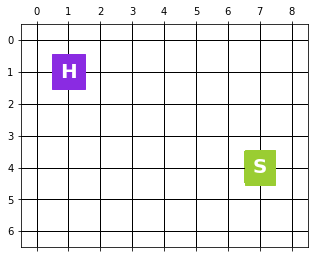

In [ ]:
# actions_dict = {0: 'up', 1: 'down', 2: 'left', 3: 'right', 4: 'up_right', 5: 'up_left', 6: 'down_right', 7: 'down_left'}
arrows = ['\u2191', '\u2193', '\u2190', '\u2192', '\u2197', '\u2196', '\u2198', '\u2199']

def show_map(map):
    row_labels, col_labels = range(map.shape[0]), range(map.shape[1])
    cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
    norm = Normalize(vmin=0, vmax=2)
    plt.matshow(map, cmap=cmap, norm=norm)
    plt.xticks(col_labels, col_labels)
    plt.yticks(row_labels, row_labels)
    plt.grid(color='k', linewidth=1)
    init = np.where(map == 1)
    plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', backgroundcolor='blueviolet', fontsize=20)
    goal = np.where(map == 2)
    plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', backgroundcolor='yellowgreen', fontsize=20)
    plt.show()

show_map(map)

Created with help of: https://www.gymlibrary.dev/content/environment_creation/

In [ ]:
class AzkabanEnviroment:
    def __init__(self, map, init_pos, goal_pos, prob_A=0.9, prob_B=0.8, prob_C=0.9):
        self.map = map
        self.size = (self.map.shape[1], self.map.shape[0])
        self.harry_pos = init_pos
        self.sirius_pos = goal_pos
        self.reset_map = map
        self.reset_harry_pos = init_pos
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Discrete(self.map.shape[0] * self.map.shape[1])
        self.prob_A = prob_A
        self.prob_B = prob_B
        self.prob_C = prob_C
        self._action_to_direction = {
            0: 'up', 
            1: 'down', 
            2: 'left', 
            3: 'right', 
            4: 'up_right', 
            5: 'up_left', 
            6: 'down_right', 
            7: 'down_left'
        }
        self._rewards = {
            "walk": -1,
            "fall": -10,
            "goal": 100
        }
    
    def get_actions(self, action):
        return self._action_to_direction[action]
    
    def get_rewards(self):
        return self._rewards
    
    def set_rewards(self, walk , fall, goal):
        self._rewards = {
            "walk": walk,
            "fall": fall,
            "goal": goal
        }

    def __str__(self):
        return f"Harry Position: ({self.harry_pos[0]}, {self.harry_pos[1]})\n" + str(self.map)

    def render(self):
        row_labels, col_labels = range(self.map.shape[0]), range(self.map.shape[1])
        cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
        norm = Normalize(vmin=0, vmax=2)
        plt.matshow(self.map, cmap=cmap, norm=norm)
        plt.xticks(col_labels, col_labels)
        plt.yticks(row_labels, row_labels)
        plt.grid(color='k', linewidth=1)
        init = np.where(self.map == 1)
        plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', fontsize=15)
        goal = np.where(self.map == 2)
        plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', fontsize=15)
        plt.show()
    
    def reset(self):
        self.map = self.reset_map
        self.harry_pos = self.reset_harry_pos
        return self.harry_pos[1] * self.size[1] + self.harry_pos[0] #10 * self.harry_pos[1] + self.harry_pos[1] #given state

    def is_goal_state(self):
        return self.harry_pos == self.sirius_pos
    
    def has_fallen_of_map(self):
        x_range = np.array(range(self.size[0]))
        y_range = np.array(range(self.size[1]))
        return (self.harry_pos[0] not in x_range) or (self.harry_pos[1] not in y_range)
    
    def move_harry_right(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[0] += 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()

    def move_harry_left(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[0] -= 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()
    
    def move_harry_up(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[1] -= 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()

    def move_harry_down(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[1] += 1
        self.harry_pos = tuple(self.harry_pos)
        return self.get_move_result()
    
    def move_harry_up_right(self):
        self.move_harry_up()
        self.move_harry_right()
        return self.get_move_result()

    def move_harry_up_left(self):
        self.move_harry_up()
        self.move_harry_left()
        return self.get_move_result()

    def move_harry_down_right(self):
        self.move_harry_down()
        self.move_harry_right()
        return self.get_move_result()

    def move_harry_down_left(self):
        self.move_harry_down()
        self.move_harry_left()
        return self.get_move_result()
    # [7, 9] = (63)
    
    def get_move_result(self):
        new_state = self.harry_pos[1] * self.size[1] + self.harry_pos[0]
        if self.is_goal_state():
            return new_state, self._rewards["goal"], True
        if self.has_fallen_of_map():
            return new_state, self._rewards["fall"], True
        
        self.map = create_map(self.size, self.harry_pos, self.sirius_pos)
        return new_state, self._rewards["walk"], False
        
    def step(self, action):
        direction = self._action_to_direction[action]
        if direction == "left":
            new_state, reward, done = self.move_harry_left()
        elif direction == "right":
            new_state, reward, done = self.move_harry_right()
        elif direction == "up":
            new_state, reward, done = self.move_harry_up()
        elif direction == "down":
            new_state, reward, done = self.move_harry_down()
        elif direction == "up_right":
            new_state, reward, done = self.move_harry_up_right()
        elif direction == "up_left":
            new_state, reward, done = self.move_harry_up_left()
        elif direction == "down_right":
            new_state, reward, done = self.move_harry_down_right()
        elif direction == "down_left":
            new_state, reward, done = self.move_harry_down_left()
            
        # probability windy columns
        if self.harry_pos[0] == 3:
            random_number = np.random.rand()
            if random_number <= self.prob_A:
                new_state, reward, done = self.move_harry_up()
            else:
                new_state, reward, done = self.get_move_result()

        if self.harry_pos[0] == 4:
            random_number = np.random.rand()
            if random_number <= self.prob_B:
                new_state, reward, done = self.move_harry_up()
                new_state, reward, done = self.move_harry_up()
            else:
                new_state, reward, done = self.get_move_result()

        if self.harry_pos[0] == 5:
            random_number = np.random.rand()
            if random_number <= self.prob_C:
                new_state, reward, done = self.move_harry_up()
            else:
                new_state, reward, done = self.get_move_result()

        return new_state, reward, done
    
    def close(self):
        clear_output(wait=True)

Create Azkaban environment as follows:

In [ ]:
map_size = (9, 7)
init_pos = (1, 1)
goal_pos = (7, 4)
azkaban_map = create_map(map_size, init_pos, goal_pos)
env = AzkabanEnviroment(azkaban_map, init_pos, goal_pos)

Render the environment, visualization of the current state of the environment

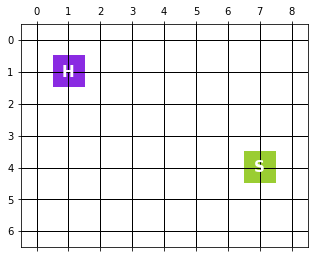

In [ ]:
env.render()

Get states and actions for the lake





In [ ]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

print((action_space_size, state_space_size))

(8, 63)


Move the agent: 

down


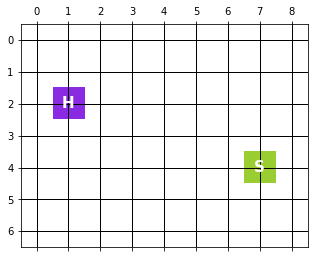

In [ ]:
action = env.action_space.sample()
state = env.reset() #*10
new_state, reward, done = env.step(action)
print(env.get_actions(action))
env.render()

Initialize some parameters

In [ ]:
num_episodes = 6000 #15000
max_steps_per_episode = 100 #100

learning_rate = 0.1
discount_rate = 0.95

rewards_avg = []

#state_space_size = 120
q_table = np.zeros((state_space_size, action_space_size))

print(q_table.shape)

(63, 8)


# Q-Learning algorithm
Our code defines a function called train_q_table that is responsible for training a Q table using the Q-learning reinforcement learning algorithm in a specific 'env' environment.

The training process is done in several episodes. In each episode, the agent interacts with the environment by taking actions and updating the Q table based on the rewards received. A trade-off strategy between exploration and exploitation is used to balance the exploration of new stocks and the exploitation of the stocks that appear to be the most optimal so far.

The Q table is initialized with zeros and is updated at each episode step using the equation of the Q-learning algorithm. In addition, a learning rate (learning_rate) and a discount factor (discount_rate) are used to adjust the influence of future rewards on updating the Q table values.

After each episode, the reward earned is recorded and the exploration parameter (exploration_rate) is updated to gradually decrease exploration as more knowledge is accumulated.

Finally, the updated Q table is returned at the end of the training process.

This algorithm is based on the Frozen-lake lab algorithm.

It performs 6000 episodes, 100 times in order to view the average of the 100 times and verify if the agent is really learning to maximize its reward.

In [ ]:
def train_q_table(env, rewards_avg, iteration=100, learning_rate=0.95, discount_rate=0.95, num_episodes=6000, max_steps_per_episode=100):
    for it in range(iteration):
        print('average ', it)
        rewards_all_episodes=[]

        # exporation-exploitation trade-off params
        exploration_rate = 1
        max_exploration_rate = 1
        min_exploration_rate = 0.01
        exploration_decay_rate = 0.005

        # init q table in zeros
        q_table = np.zeros((state_space_size, action_space_size))

        # iterate over the episodes
        for episode in range(num_episodes):
            state = env.reset()
            done = False
            rewards_current_episode = 0

            # iterate over the steps for an episode
            for step in range(max_steps_per_episode):
                # Exploration-exploitation trade-off
                exploration_rate_threshold = np.random.rand()
                if exploration_rate_threshold <= exploration_rate:
                    action = np.random.randint(0, action_space_size) # Exploration time
                else:
                    action = np.argmax(q_table[state]) # Explotation time

                # Take action
                new_state, reward, done = env.step(action)

                # Update Q-table for Q(s,a)
                q_table[state, action] = (1-learning_rate) * q_table[state, action] + learning_rate * (reward + discount_rate * np.max(q_table[new_state]))
                
                # transition next state
                state = new_state
                rewards_current_episode += reward

                if done == True: 
                    break


            # Exploration rate decay
            exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * (np.exp(-exploration_decay_rate * episode)) #your code here
            #env.render()
            rewards_all_episodes.append(rewards_current_episode)

        rewards_avg.append(rewards_all_episodes)
    return q_table

In [ ]:
# Applying Q-learning
walk_reward = -1
fall_reward = -10
goal_reward = 150

env.reset()
env.set_rewards(walk_reward , fall_reward, goal_reward)

rewards_avg_test = []
iteration = 100
learning_rate = 0.1
discount_rate = 0.95
num_episodes = 6000 #15000
max_steps_per_episode = 100 #100
q_table_1 = train_q_table(env, rewards_avg_test, iteration, learning_rate, discount_rate, num_episodes, max_steps_per_episode)

average  0
average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
av

2. Find the optimal policy (graph every action that the agent can take) and graph the averag Reward Over Time

# Visualization
Here we can see how the performance of agent H improves as more training episodes are performed

In [ ]:
def plot_rewards_episodes(rewards_avg, num_episodes):
    x = [i for i in range(0, num_episodes)]
    y = np.mean(rewards_avg, axis=0)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.plot(x, y,'o')

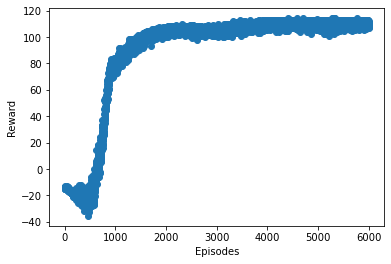

In [ ]:
plot_rewards_episodes(rewards_avg_test, num_episodes)

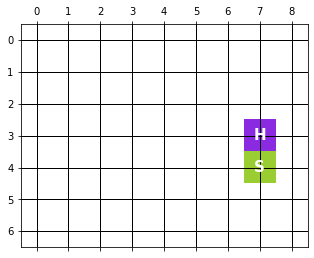

In [ ]:
env.render()

In [ ]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table_1)



********Q-table********

[[-3.43900000e+00 -2.83238461e+00 -4.09510000e+00  2.51427762e+01
  -4.68559000e+00 -4.09510000e+00 -2.92256750e+00 -4.19010000e+00]
 [-6.86189404e+00  6.95507370e+01 -2.88259017e+00 -2.87544626e+00
  -5.21703100e+00 -6.12579511e+00 -2.86237987e+00 -2.91537874e+00]
 [-5.21703100e+00 -2.86245254e+00 -2.85076275e+00 -5.89284970e+00
  -4.68559000e+00 -6.12579511e+00 -2.90156586e+00  7.49256011e+01]
 [-4.68559000e+00 -3.05804712e+00 -3.08761530e+00 -3.43900000e+00
  -5.21703100e+00 -5.69532790e+00 -4.68559000e+00  3.10793441e+01]
 [-4.68559000e+00 -2.55268527e+00 -3.43900000e+00 -3.43900000e+00
  -2.71000000e+00 -3.43900000e+00  2.80949450e+01 -2.26470118e+00]
 [-4.09510000e+00 -1.79881032e+00 -2.82668866e+00 -1.76669338e+00
  -2.71000000e+00 -1.90000000e+00  8.98757645e+01 -3.43900000e+00]
 [-1.90000000e+00  8.82865634e+00 -1.90000000e+00 -1.47636407e+00
  -2.22793843e+00 -1.90000000e+00 -1.44798968e+00 -1.40417814e+00]
 [-4.05358163e+00 -3.15714926e+00 -5.33802

In [ ]:
def best_pos_max(matrix):
    posiciones_maximas = np.argmax(matrix, axis=1)
    matriz_resultante = posiciones_maximas.reshape(1, -1)
    return matriz_resultante

pos_best_moves = best_pos_max(q_table_1)
print(pos_best_moves)

[[3 1 7 7 6 6 1 6 6 1 7 6 6 1 1 6 1 6 6 3 6 4 4 6 6 6 4 7 1 5 4 6 3 7 0 3
  5 4 4 4 0 3 4 5 2 5 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


Here, we identify  the best actions for each state based on the Q values in the q_table_1 matrix, these Q values represent the expected reward for taking those actions in each state

In [ ]:
index_array = np.argmax(q_table_1, axis=-1)
best_moves = np.take_along_axis(q_table_1, np.expand_dims(index_array, axis=-1), axis=-1)
print(best_moves)

[[ 25.14277621]
 [ 69.55073697]
 [ 74.92560113]
 [ 31.07934406]
 [ 28.09494502]
 [ 89.87576453]
 [  8.82865634]
 [ 35.20917269]
 [ 96.78356937]
 [ 86.24265446]
 [ 89.52920593]
 [120.34784551]
 [131.37313523]
 [127.37555126]
 [ 44.29605139]
 [ 99.58253049]
 [102.84009981]
 [105.69157031]
 [124.05788341]
 [131.63987727]
 [139.62092344]
 [ 87.95029755]
 [ 83.27254178]
 [109.26727658]
 [116.51083174]
 [120.11732434]
 [131.63987727]
 [114.26624671]
 [148.02202468]
 [ 35.47507749]
 [ 57.06851914]
 [115.27370206]
 [121.90538583]
 [115.12707492]
 [ 37.58712111]
 [ -2.08207929]
 [ 64.3206076 ]
 [ -1.20594232]
 [ 11.17954425]
 [122.89665712]
 [ 23.57099785]
 [  0.        ]
 [ -0.91361758]
 [ -1.820818  ]
 [ -1.04658001]
 [ -0.15448744]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.  

The following code finds the best actions (action indices) for each state based on the Q values stored in the q_table_1 array and stores them in the state_best_actions list. Then, it creates an arrow_matrix matrix that shows the arrow representations corresponding to the best actions for each state.

In [ ]:
# action_space = [up, down, left, right, ...] 
state_best_actions =[]
arrow_matrix = []
for i in range(q_table_1.shape[0]):
    max_pos = np.argmax(q_table_1[i])
    state_best_actions.append(max_pos)
arrow_matrix = np.array(state_best_actions).reshape(7,9)

print(state_best_actions)
print(arrow_matrix)

[3, 1, 7, 7, 6, 6, 1, 6, 6, 1, 7, 6, 6, 1, 1, 6, 1, 6, 6, 3, 6, 4, 4, 6, 6, 6, 4, 7, 1, 5, 4, 6, 3, 7, 0, 3, 5, 4, 4, 4, 0, 3, 4, 5, 2, 5, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[3 1 7 7 6 6 1 6 6]
 [1 7 6 6 1 1 6 1 6]
 [6 3 6 4 4 6 6 6 4]
 [7 1 5 4 6 3 7 0 3]
 [5 4 4 4 0 3 4 5 2]
 [5 2 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


Here we extract the best actions from the Q table and represent them in a matrix that shows the directions of the actions for each state on the map

First an empty list named state_best_actions is created to store the best actions (action indices) for each state and an empty array named arrow_matrix to store the arrow representations corresponding to the best actions for each state.
Then, in a loop, the rows of the q_table array are traversed and the function np.argmax(q_table[i]) is used to find the index of the action with the maximum Q value for each state i, this index represents the best action for that state.
The best action index is added to the state_best_actions list. Also, convert the state_best_actions list to a NumPy array and
reshape(map.shape[0], map.shape[1]) is used to shape the arrow_matrix using the dimensions of the map.

Finally, the arrow_matrix matrix is returned, representing the best actions for each map state.

In [ ]:
def policies_matrix(q_table, map):
    state_best_actions =[]
    arrow_matrix = []
    for i in range(q_table.shape[0]):
        max_pos = np.argmax(q_table[i])
        state_best_actions.append(max_pos)
    arrow_matrix = np.array(state_best_actions).reshape(map.shape[0], map.shape[1])
    return arrow_matrix

In [ ]:
policies_matrix = policies_matrix(q_table_1, map)
print(policies_matrix)

[[3 1 7 7 6 6 1 6 6]
 [1 7 6 6 1 1 6 1 6]
 [6 3 6 4 4 6 6 6 4]
 [7 1 5 4 6 3 7 0 3]
 [5 4 4 4 0 3 4 5 2]
 [5 2 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


# Optimal Policy

The show_optimal_policy function displays a graphical representation of the map and the optimal policies for each state on the map. Colors and Unicode arrows are used to visualize different types of cells and the best actions to take from each state. The map is displayed with a color palette representing empty spaces, the starting point, and the goal. Arrow texts are added in each cell of the map to indicate the corresponding best action. Parameters such as row and column labels, color palette, normalization, and Unicode arrows are used to configure and customize the map's rendering and optimal policies. At the end, the resulting graph is displayed.

In [ ]:
def show_optimal_policy(map):
    row_labels, col_labels = range(map.shape[0]), range(map.shape[1])
    cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
    norm = Normalize(vmin=0, vmax=2) # normalization for color values using
    plt.matshow(map, cmap=cmap, norm=norm)
    plt.xticks(col_labels, col_labels)
    plt.yticks(row_labels, row_labels)
    plt.grid(color='k', linewidth=1)
    init = np.where(map == 1)
    plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', backgroundcolor='blueviolet', fontsize=20)
    goal = np.where(map == 2)
    plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', backgroundcolor='yellowgreen', fontsize=20)

    arrows = ['\u2191', '\u2193', '\u2190', '\u2192', '\u2197', '\u2196', '\u2199', '\u2198']
    for i, row in enumerate(map):
        for j, cell in enumerate(row):
            if cell == 0:
                plt.text(j, i, arrows[0], ha='center', va='center', color='black', weight='bold', backgroundcolor='lightblue', fontsize=20)
            elif cell == 1:
                plt.text(j, i, arrows[1], ha='center', va='center', color='black', weight='bold', backgroundcolor='lightblue', fontsize=20)
            elif cell == 2:
                plt.text(j, i, arrows[2], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 3:
                plt.text(j, i, arrows[3], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 4:
                plt.text(j, i, arrows[4], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 5:
                plt.text(j, i, arrows[5], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 6:
                plt.text(j, i, arrows[6], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)
            elif cell == 7:
                plt.text(j, i, arrows[7], ha='center', va='center', color='black', backgroundcolor='lightblue', fontsize=20)

    plt.show()

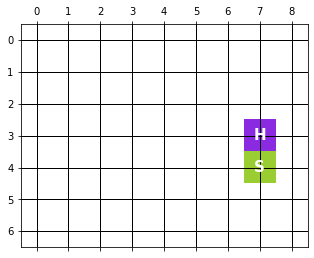

In [ ]:
env.render()

Harry init action: down_left
Harry end action: up_left


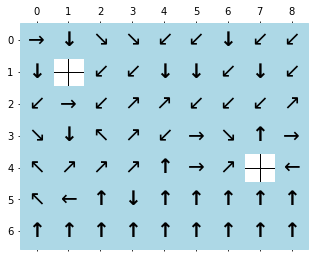

In [ ]:
print('Harry init action:', actions[arrow_matrix[1][1]])
print('Harry end action:', actions[arrow_matrix[4][7]])
arrow_matrix[1][1] = -2
arrow_matrix[4][7] = -3
show_optimal_policy(arrow_matrix)

In [ ]:
"""
for episode in range(50):
    env_copy = copy(env)
    state = env_copy.reset()
    done = False
    print("*****EPISODE ", episode+1, "*****\n\n\n\n")
    time.sleep(1)
    
    for step in range(max_steps_per_episode):        
        clear_output(wait=True)
        env_copy.render()
        time.sleep(0.3)
        
        action = np.argmax(q_table[state,:])        
        new_state, reward, done = env_copy.step(action)
        
        if done:
            clear_output(wait=True)
            env_copy.render()
            if reward == goal_reward:
                print("****You reached the goal!****")
                time.sleep(3)
            elif reward == fall_reward:
                print("****You fell through the map!****")
                time.sleep(1)
                clear_output(wait=True)

            break
            
        state = new_state
        #env.close()
"""

'\nfor episode in range(50):\n    env_copy = copy(env)\n    state = env_copy.reset()\n    done = False\n    print("*****EPISODE ", episode+1, "*****\n\n\n\n")\n    time.sleep(1)\n    \n    for step in range(max_steps_per_episode):        \n        clear_output(wait=True)\n        env_copy.render()\n        time.sleep(0.3)\n        \n        action = np.argmax(q_table[state,:])        \n        new_state, reward, done = env_copy.step(action)\n        \n        if done:\n            clear_output(wait=True)\n            env_copy.render()\n            if reward == goal_reward:\n                print("****You reached the goal!****")\n                time.sleep(3)\n            elif reward == fall_reward:\n                print("****You fell through the map!****")\n                time.sleep(1)\n                clear_output(wait=True)\n\n            break\n            \n        state = new_state\n        #env.close()\n'